# Test the U-Net model
* Look at some heatmaps
* Use non-max suppression and evaluate classifcation accuracy


In [1]:
import os
import sys
import pandas
import numpy as np
import glob
from scipy.ndimage import rotate
from PIL import Image
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
% matplotlib inline

import keras
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import metrics
from keras import layers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Reshape, Input, concatenate, Conv2DTranspose
from keras.layers.core import Activation, Dense, Lambda
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
def create_heatmap(image_loc, model, height, downsample):
    def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    image = np.asarray(Image.open(image_loc))
    image_shape = image.shape
    image = image/255.0 # During training the images were normalized

    last = model.layers[-2].output
    model = Model(model.input, last)

    out_shape = np.ceil(np.array(image.shape)/float(downsample)).astype(int)
    out_shape[2] = 2 # there are 2 classes

    delta=int((height)/2)
    image = np.lib.pad(image, ((delta, delta-int(downsample)), (delta, delta-int(downsample)), (0,0)), 'constant', constant_values=(0, 0))
    image = np.expand_dims(image, axis=0)
    heat = model.predict(image, batch_size=1, verbose=0)
    heat = np.reshape(heat, out_shape)
    # now apply the softmax to only the 3 classes(not the overall class probability (why??))
    heat[:,:,:] = np.apply_along_axis(softmax, 2, heat[:,:,:])
    return heat[:,:,1]

In [3]:
def unet_standard(learning_rate=.0001):
    input_shape = (None, None, 3)
    img_input = Input(shape=input_shape)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10_dist = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    conv10_cross_entropy = Conv2D(3, (1, 1), activation='softmax')(conv9)
    output = concatenate([conv10_dist, conv10_cross_entropy])

    model = Model(img_input, output)
    model.compile(optimizer=Adam(lr=learning_rate), loss=distance_loss, metrics=[distance_loss])
    return model

def conv_block(x,
              filters,
              num_row,
              num_col,
              dropout, 
              padding='same',
              strides=(1, 1),
              activation='relu'):
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, activation=activation)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, activation=activation)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    return x

def unet_paper(learning_rate=.0001):
    input_shape = (None, None, 3)
    img_input = Input(shape=input_shape)

    conv1 = conv_block(img_input, 32, 3, 3, dropout = .1, padding='same', strides=(1, 1), activation='relu')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 64, 3, 3, dropout = .1, padding='same', strides=(1, 1), activation='relu')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128, 3, 3, dropout = .1, padding='same', strides=(1, 1), activation='relu')
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 128, 3, 3, dropout = .1, padding='same', strides=(1, 1), activation='relu')

    up5 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = conv_block(up5, 128, 3, 3, dropout = .1, padding='same', strides=(1, 1), activation='relu')

    up6 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = conv_block(up6, 64, 3, 3, dropout = .1, padding='same', strides=(1, 1), activation='relu')

    up7 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = conv_block(up7, 32, 3, 3, dropout = .1, padding='same', strides=(1, 1), activation='relu')
    
    conv8_dist = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    conv8_cross_entropy = Conv2D(3, (1, 1), activation='softmax')(conv7)
    output = concatenate([conv8_dist, conv8_cross_entropy])
    
    model = Model(img_input, output)
    model.compile(optimizer=Adam(lr=learning_rate), loss=distance_loss, metrics=[distance_loss])
    return model


def distance_loss(y_true, y_pred):
    weight = .5 # how mush does the distance matter compared to the cross entropy (fast ai used .001 for 4 more uncertain ones)
    distance_loss = K.binary_crossentropy(y_pred[:, :, :, 0], y_true[:, :, :, 0])    
    cross_entropy = K.categorical_crossentropy(y_true[:, :, :, 1:], y_pred[:, :, :, 1:])    

    return(distance_loss*weight+(1-weight)*cross_entropy)

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import scipy.misc
import random
from shutil import copyfile
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from PIL import Image
from scipy.spatial.distance import cdist
from bs4 import BeautifulSoup
import xml.etree.cElementTree as ET
from numpy import linalg as LA

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

from scipy.spatial import distance

def get_points_from_xml(xml_file):
    lymphocyte=['TIL-E', 'TIL-S']
    normal_epithelial=['normal', 'UDH', 'ADH']
    malignant_epithelial=['IDC', 'ILC', 'MucC', 'DCIS1', 'DCIS2', 'DCIS3', 'MC-E', 'MC-C', 'MC-M']
    
    with open(xml_file) as fp:
        soup = BeautifulSoup(fp, 'xml')
    groups=soup.find_all('graphic')

    num_pos = 0
    all_points=[]
    for group in groups:
        points=group.find_all('point')

        nucleus_type = group.get('description').replace(" ", "")
        if (nucleus_type in lymphocyte):
            label = '1'
        elif (nucleus_type in normal_epithelial):
            label = '2'
        elif (nucleus_type in malignant_epithelial):
            label = '3'
        else:
            # convention is to use the last valid label, meaning we shouldn't change the label variable 
            try:
                label
            except NameError:
                print("Error, no matching label with no prev obs - set var to 3")
                print('nucleus_type is: ', nucleus_type)
                print('File is ', xml_file)
                label = 3
            else:
                print ("Error, set var to prev obs: ", label)
                print ('nucleus_type is: ', nucleus_type)
                print ('File is ', xml_file)

        for point in points:
            x=int(point.get_text().rsplit(',', 1)[0])
            y=int(point.get_text().rsplit(',', 1)[1])
            all_points.append([x,y, label])
    all_points = np.array(all_points).astype(float)
    return all_points


image_file =  '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/test/7_Region_0_crop.tif'
xml_file = image_file.rsplit('_', 1)[0]+'_key.xml'
points = get_points_from_xml(xml_file)

image = np.array(Image.open(image_file))
im_name = image_file.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('_', 1)[0].replace(" ", "_")
print('image.shape', image.shape)
print('points.shape', points.shape)

dist_map=np.zeros(image.shape)

for y in range(image.shape[0]): # rows
    for x in range(image.shape[1]): # cols
        dists = np.sqrt(np.sum((points[:, 0:2] -  np.array([x, y])) ** 2, axis=1))
        if (len(dists)==0):
            print('problem')
            break
        else:
            min_ind = np.argmin(dists)
            min_dist = dists[min_ind]
            dist_map[y, x, 0] = min_dist
            dist_map[y, x, 1] = points[min_ind, 2]

print(points[:, 2])

plt.figure(figsize=(10,12))
plt.imshow(dist_map[:, :, 1])
dist_map[dist_map > 20] = 20
plt.figure(figsize=(10,12))
plt.imshow(dist_map[:, :, 0])


f = plt.figure(figsize=(12,15))
image2 = np.asarray(image).astype(int)
for row in range(len(points)):
    if points[row, 2] == 1:
        color = [0, 0, 255]
    elif points[row, 2] == 2:
        color = [0, 255, 0]  
    elif points[row, 2] == 3:
        color = [255, 0, 0]
    image2[int(points[row, 1])-2:int(points[row, 1])+2, int(points[row, 0])-2:int(points[row, 0])+2, :] = color
plt.imshow(image2.astype(np.uint8))

(470, 725, 3)
(600, 1000, 3)
(600, 1000, 4)
(470, 725, 4)


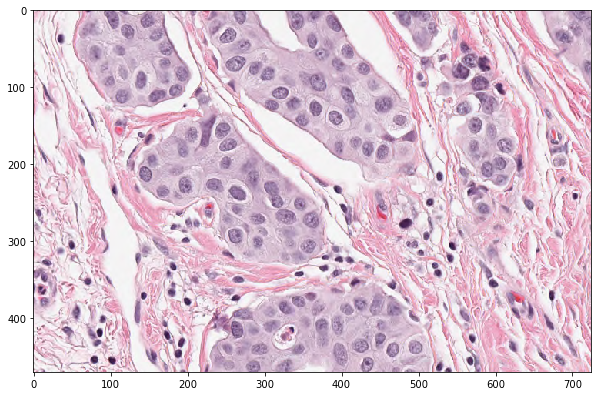

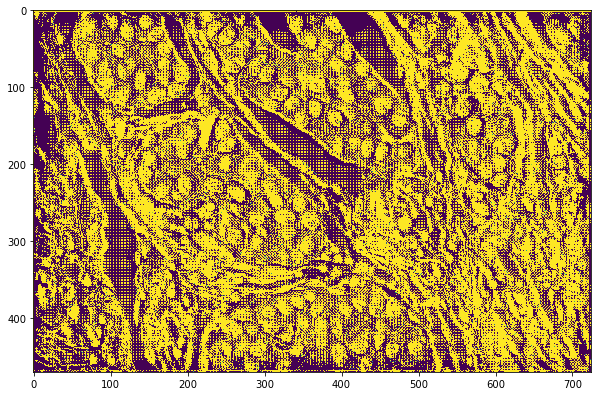

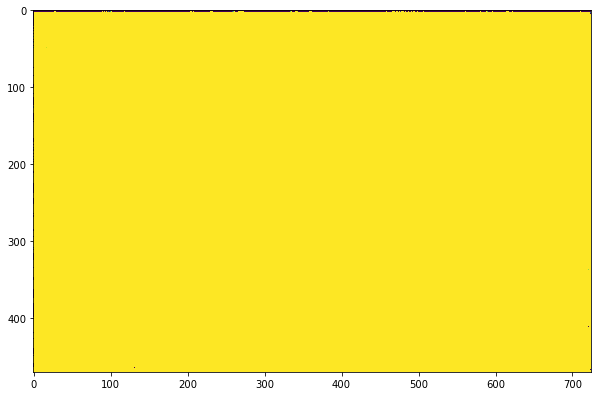

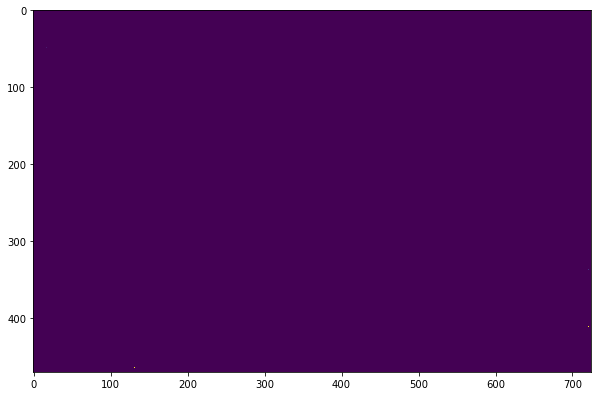

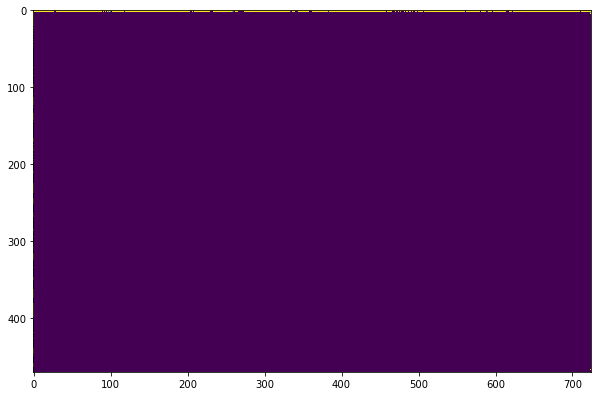

In [5]:
model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist_out/unet_dist/sshfs/unet_paper_custom_aug_0001_2/unet_paper_custom_aug_.89-154.19.hdf5'
# not from correct ttv split
image_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/test/7_Region_0_crop.tif'
image = np.asarray(Image.open(image_loc))

print(image.shape)
model = unet_paper(learning_rate=.0001)
model.load_weights(model_loc)
image_pad = np.zeros((600, 1000, 3))
print(image_pad.shape)
image_pad[:image.shape[0],:image.shape[1] , :] = image
image_pad = np.expand_dims(image_pad, axis=0)

heat = model.predict(image_pad, batch_size=1, verbose=0)
heat=np.squeeze(heat)
print(heat.shape)
heat = heat[:image.shape[0],:image.shape[1] , :]
print(heat.shape)

f = plt.figure(figsize=(10,10))
plt.imshow(image)
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 0])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 1])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 2])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 3])

In [ ]:
import keras
from keras.models import load_model, Model

sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from unet_dist_models import*

model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist_out/unet_dist/sshfs/unet_mid2_custom_aug_0001_2/unet_mid2_custom_aug_.83-161.99.hdf5'
# not from correct ttv split
image_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/test/7_Region_0_crop.tif'
image = np.asarray(Image.open(image_loc))

model = unet_mid2(learning_rate=.0001)
model.load_weights(model_loc)
image_pad = np.zeros((600, 1000, 3))
image_pad[:image.shape[0],:image.shape[1] , :] = image
image_pad = np.expand_dims(image_pad, axis=0)


heat = model.predict(image_pad, batch_size=1, verbose=0)
heat=np.squeeze(heat)
heat = heat[:image.shape[0],:image.shape[1] , :]
print(heat.shape)

f = plt.figure(figsize=(10,10))
plt.imshow(image)
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 0])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 1])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 2])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 3])

In [ ]:
model_loc = '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist_out/unet_dist/sshfs/unet_mid_custom_aug_0001_2/unet_mid_custom_aug_.24-217.91.hdf5'
# not from correct ttv split
image_loc = '/Users/rb/Documents/waterloo/projects/cancer_hist/full_slides/test/7_Region_0_crop.tif'
image = np.asarray(Image.open(image_loc))

model = unet_mid(learning_rate=.0001)
model.load_weights(model_loc)
image_pad = np.zeros((600, 1000, 3))
image_pad[:image.shape[0],:image.shape[1] , :] = image
image_pad = np.expand_dims(image_pad, axis=0)


heat = model.predict(image_pad, batch_size=1, verbose=0)
heat=np.squeeze(heat)
heat = heat[:image.shape[0],:image.shape[1] , :]
print(heat.shape)

f = plt.figure(figsize=(10,10))
plt.imshow(image)
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 0])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 1])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 2])
f = plt.figure(figsize=(10,10))
plt.imshow(heat[:, :, 3])

## Test Performance

In [54]:
sys.path.insert(0, '/home/rbbidart/cancer_hist/src')

from unet_dist_models import*
from functions import*
import pickle

def check_performance_unet(model_loc, data_loc, model_str):
    # Graph performance
    model_dir = model_loc.rsplit('/', 1)[0]
    everything=glob.glob(model_dir+'/**/*', recursive=True)
    all_hist = [loc for loc in everything if '.hdf5' not in loc]
    if all_hist is not None:
        for loc in all_hist:
            data = pickle.load(open( loc, "rb" ))
            name = loc.rsplit('/', 1)[-1]
            print(name, 'Final 5 Epochs Validation loss: ', np.mean(data['val_distance_loss'][-5:]))
            plt.plot(data['distance_loss'])
            plt.plot(data['val_distance_loss'])
            plt.title(name)
            plt.ylabel('Accuracy')
            plt.xlabel('epoch')
            plt.legend(['distance_loss', 'val_distance_loss'], loc='upper left')
            plt.figure(figsize=(40,10))
            plt.show()

    # look at examples:
    functionList = {
    'unet_standard': unet_standard,
    'unet_mid': unet_mid,
    'unet_mid2': unet_mid2,
    'unet_paper': unet_paper
    }
    
    model = functionList[model_str](learning_rate = .0001 )
    model.load_weights(model_loc)
    
    all_images=glob.glob(data_loc+'/**/*.tif', recursive=True)
    image_locs = np.random.choice(all_images, 4)
    
    all_matched_preds = []
    all_matched_pts = []
    total_nuclei = 0
    num_predicted = 0
    abs_error_list = 0
    

    f = plt.figure(figsize=(15, 15))
    for img_num, img_locs in enumerate(image_locs):
        xml_loc = img_locs.replace('crop.tif', 'key.xml')
        image = np.asarray(Image.open(img_locs))
        
        image_pad = np.zeros((512, 1024, 3))
        image_pad[:image.shape[0],:image.shape[1] , :] = image
        image_pad = np.expand_dims(image_pad, axis=0)

        heat = model.predict(image_pad, batch_size=1, verbose=0)
        heat = np.squeeze(heat)
        heat = heat[:image.shape[0],:image.shape[1] , :]
        print(heat.shape)

        true_pts = get_points_xml(xml_loc)
        preds = non_max_supression(heatmap=heat, radius=10, cutoff = .9, stride = 1)

        sp = f.add_subplot(3, 6//3, 2*img_num+1)
        sp.axis('Off')
        sp.set_title('Raw Image - Estimated points', fontsize=20)
        image2 = np.array(image)
        for row in range(len(preds)):
            if preds[row, 2] == 1:
                color = [0, 0, 255]
            elif preds[row, 2] == 2:
                color = [0, 255, 0]  
            elif preds[row, 2] == 3:
                color = [255, 0, 0]
            image2[int(preds[row, 0])-2:int(preds[row, 0])+2, int(preds[row, 1])-2:int(preds[row, 1])+2, :] = color
        plt.tight_layout()
        plt.imshow(image2)

        sp = f.add_subplot(3, 6//3, 2*img_num+2)
        sp.axis('Off')
        sp.set_title('Raw Image - Actual points', fontsize=20)
        image2 = np.array(image)
        for row in range(len(true_pts)):
            if true_pts[row, 2] == 1:
                color = [0, 0, 255]
            elif true_pts[row, 2] == 2:
                color = [0, 255, 0]
            elif true_pts[row, 2] == 3:
                color = [255, 0, 0]
            image2[int(true_pts[row, 0])-2:int(true_pts[row, 0])+2, int(true_pts[row, 1])-2:int(true_pts[row, 1])+2, :] = color
        plt.tight_layout()
        plt.imshow(image2)

        # find overall accuracy
        tp_temp = true_pts 
        for index, point in enumerate(preds):
            dists = np.sqrt(np.sum((point[0:2] - tp_temp[:, 0:2]) ** 2, axis=1))
            if (len(dists)==0):
                break
            else:
                min_ind = np.argmin(dists)
                # if point has matching prediction, append it and increment the number of matched points
                if (dists[min_ind] < 10):
                    all_matched_preds.append(preds[index, 2:])
                    all_matched_pts.append(tp_temp[min_ind, :])
                    tp_temp = np.delete(tp_temp, (min_ind), axis=0) # If the point is matched, delete from list


        # Add the numbers for each image:
        total_nuclei += len(true_pts)
        num_predicted += len(preds)
        abs_error_list = abs(len(true_pts)-len(preds))

    acc = {}
    acc["all_matched_preds"] = np.array(all_matched_preds)
    acc["all_matched_pts"] = np.array(all_matched_pts)
    acc["total_nuclei"] = total_nuclei
    acc["num_predicted"] = num_predicted
    acc["abs_error"] = abs_error_list

unet_standard_custom_aug Final 5 Epochs Validation loss:  232.480183105


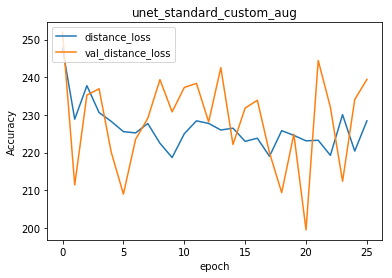

(402, 575, 4)
(473, 710, 4)
(413, 600, 4)
(442, 584, 4)


ValueError: num must be 1 <= num <= 6, not 7

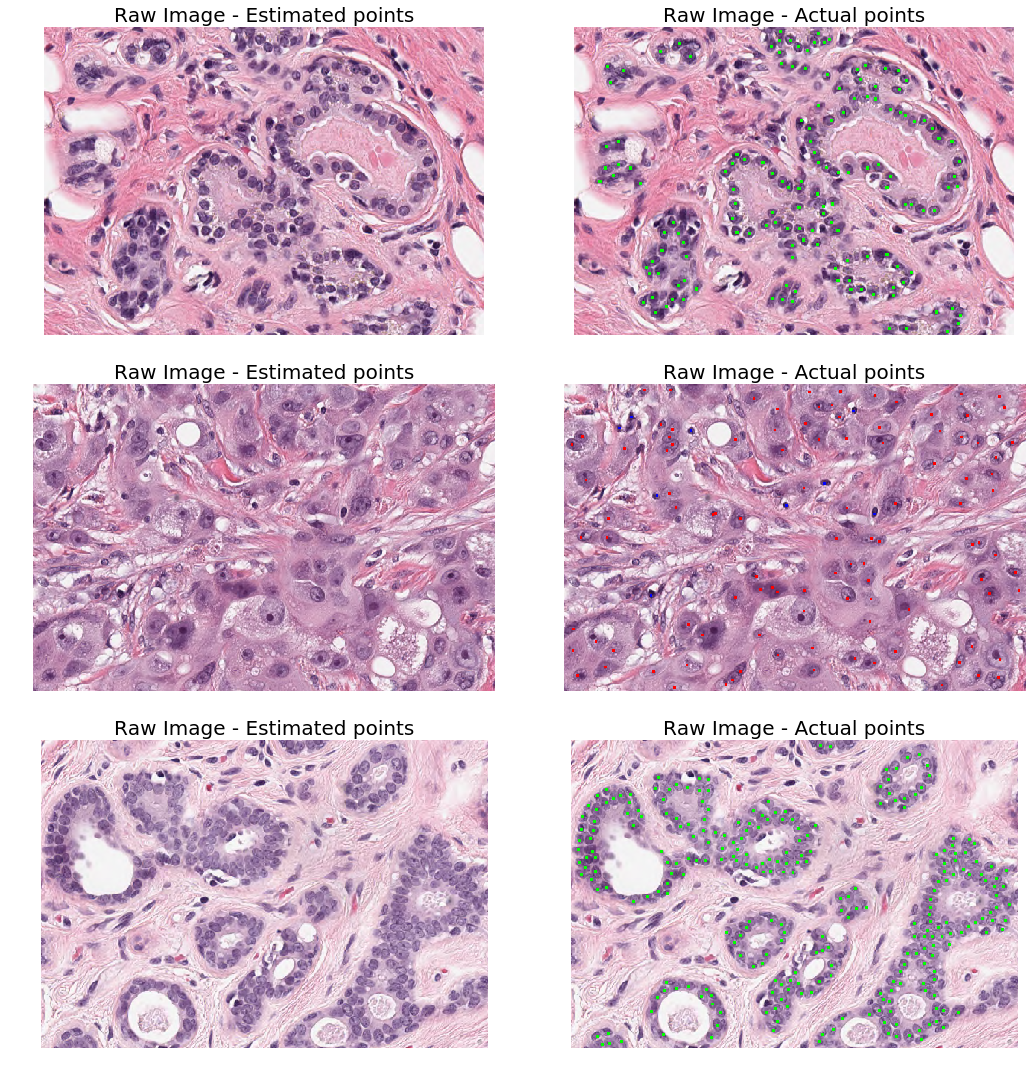

In [55]:
model_loc='/home/rbbidart/cancer_hist_out/unet_dist/dist_loss_only_standard/unet_standard_custom_aug_.09-218.67.hdf5'
data_loc='/home/rbbidart/project/rbbidart/cancer_hist/full_slides2/test/0'
model_str='unet_standard'

check_performance_unet(model_loc, data_loc, model_str)